In [1]:
"""Volume 3: Non-negative Matrix Factorization."""

import numpy as np
import cvxpy as cp
from matplotlib import pyplot as plt
import os
from imageio import imread
import warnings
warnings.filterwarnings("ignore")
from sklearn.decomposition import NMF
from sklearn.metrics import mean_squared_error as mse

In [2]:
#Problems 1-2
class NMFRecommender:

    def __init__(self, random_state=15, rank=3, maxiter=200, tol=1e-3):
        """The parameter values for the algorithm"""

        self.random_state = random_state
        self.rank = rank
        self.maxiter = maxiter
        self.tol = tol
    
    def initialize_matrices(self, m, n):
        """randomly initialize the W and H matrices,"""
        np.random.seed(self.random_state)
        self.W = np.random.random((m, self.rank))
        self.H = np.random.random((self.rank, n))
      
    def fit(self,V):
        """Fits W and H weight matrices using CVXPY"""

        # initialize our random matrices
        self.initialize_matrices(V.shape[0], V.shape[1])

        # create variables with values
        W = cp.Variable(self.W.shape, nonneg=True)
        H = cp.Variable(self.H.shape, nonneg=True)
        W.value = self.W
        H.value = self.H

        # iterate at most maxiter times to solve the problem
        # switching off which problem to solve
        for _ in range(self.maxiter):

            # solve 1
            objective = cp.Minimize(cp.norm(V - W@H.value, 'fro'))
            problem = cp.Problem(objective)
            result = problem.solve()

            # solve 2
            objective = cp.Minimize(cp.norm(V - W.value@H, 'fro'))
            problem = cp.Problem(objective)
            result = problem.solve()

            if np.linalg.norm(V - W.value @ H.value, ord='fro') < self.tol:
                break

        self.W = W.value
        self.H = H.value
        return result

    def reconstruct(self):
        """Reconstruct V matrix for comparison against the original V"""
        return self.W@self.H


In [3]:
def prob3():
    """Run NMF recommender on the grocery store example"""
    V = np.array(
        [
            [0, 1, 0, 1, 2, 2],
            [2, 3, 1, 1 ,2, 2],
            [1, 1, 1, 0, 1, 1],
            [0, 2, 3, 4, 1, 1],
            [0, 0, 0, 0, 1, 0]
        ]
    )

    # build object
    NMF = NMFRecommender(rank=2)
    # fit the model
    result = NMF.fit(V)
    # return W and H
    W, H = NMF.W, NMF.H

    num_of_people = np.sum(np.argmax(H, axis=0) == np.ones(H.shape[1]))

    return W, H, num_of_people 

W, H, num_of_people = prob3()
print('W:', W, sep='\n')
print('H:', H, sep='\n')
print('Numer of people who have higher weights in component 2 than component 1:', num_of_people, sep=' ')

W:
[[4.32480191e-01 1.55954416e+00]
 [7.28906415e-01 2.67373283e+00]
 [2.59466489e-01 1.23238130e+00]
 [2.77259088e+00 7.64369539e-08]
 [2.08546906e-09 3.68889128e-01]]
H:
[[4.28503903e-08 7.25973906e-01 1.07543057e+00 1.44598707e+00
  3.52852850e-01 3.65398494e-01]
 [5.85611950e-01 7.72213331e-01 6.59496409e-02 5.89472429e-09
  8.03616848e-01 7.67499335e-01]]
Numer of people who have higher weights in component 2 than component 1: 4


In [4]:
#get data
def get_faces(path="./faces94"):
    """Traverse the specified directory to obtain one image per subdirectory.
    Flatten and convert each image to grayscale.

    Parameters:
        path (str): The directory containing the dataset of images.

    Returns:
        ((mn,k) ndarray) An array containing one column vector per
            subdirectory. k is the number of people, and each original
            image is mxn.
    """
    # Traverse the directory and get one image per subdirectory.
    faces = []
    for (dirpath, dirnames, filenames) in os.walk(path):
        for fname in filenames:
            if fname[-3:]=="jpg":       # Only get jpg images.
                # Load the image, convert it to grayscale,
                # and flatten it into a vector.
                faces.append(np.ravel(imread(dirpath+"/"+fname, as_gray=True)))
                break
    # Put all the face vectors column-wise into a matrix.
    return np.transpose(faces)

def show(image, m=200, n=180, plt_show=False):
    """Plot the flattened grayscale 'image' of width 'w' and height 'h'.

    Parameters:
        image ((mn,) ndarray): A flattened image.
        m (int): The original number of rows in the image.
        n (int): The original number of columns in the image.
        plt_show (bool): if True, call plt.show() at the end
    """
    #scale image
    image = image / 255
    #reshape image
    image = np.reshape(image,(m,n))
    #show image
    plt.imshow(image,cmap = "gray")
    
    if plt_show:
        plt.show()


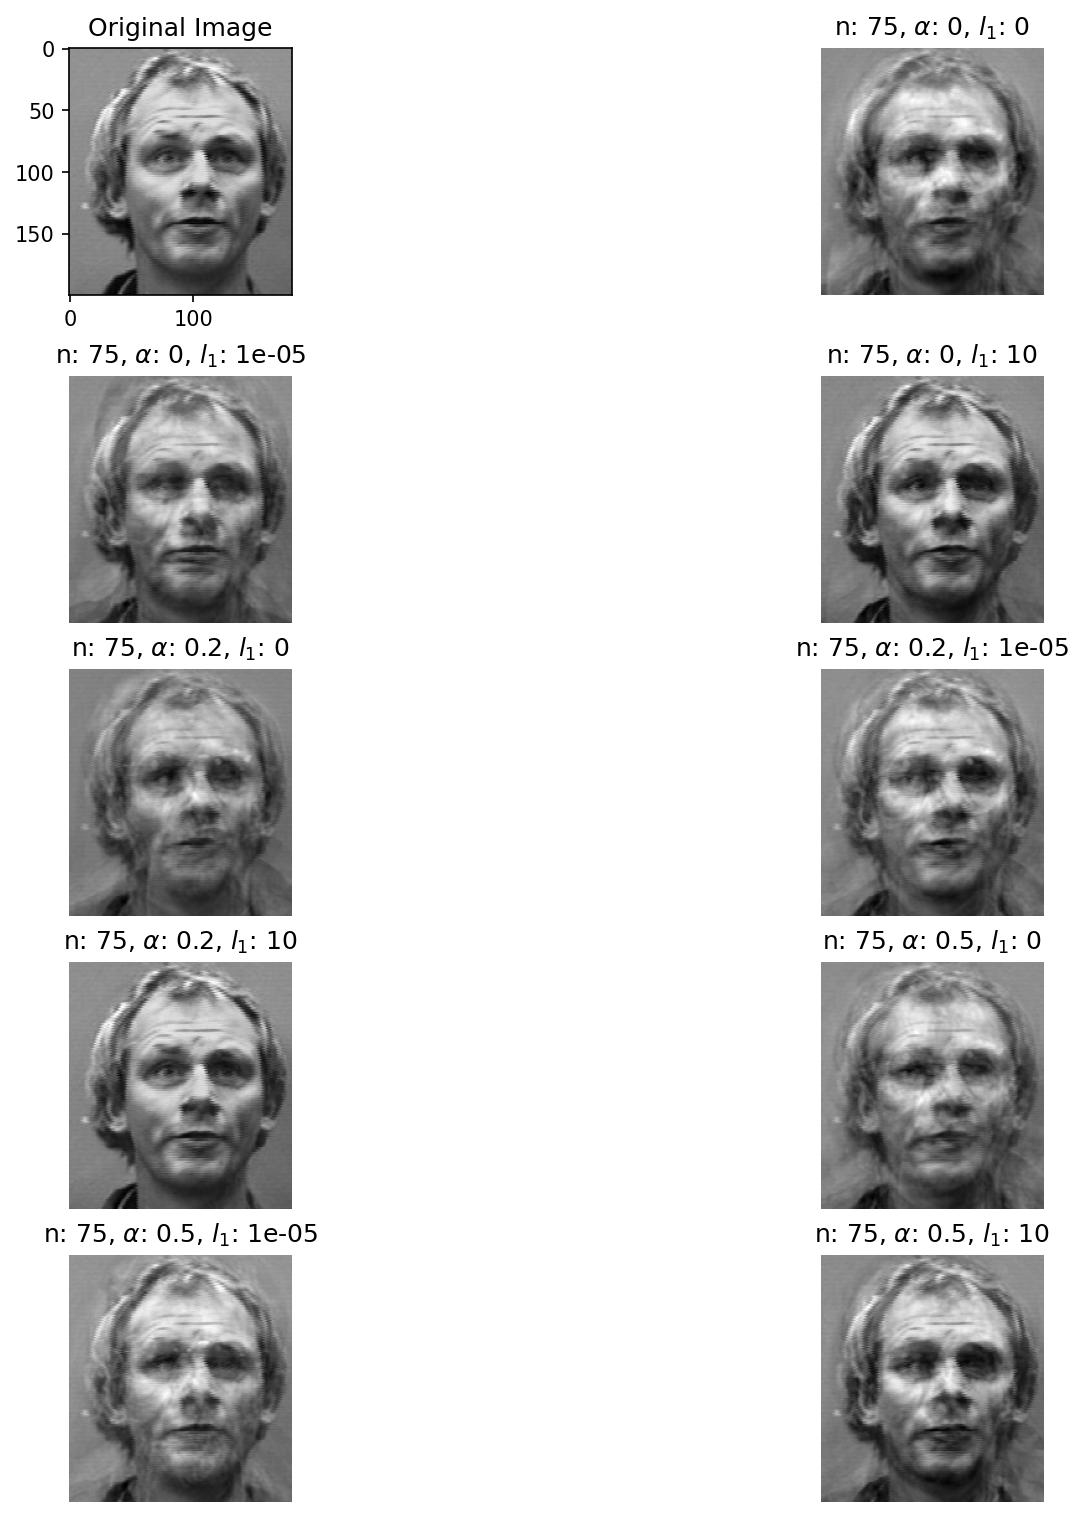

In [5]:
def prob4(n, alpha_vals, l1_ratio):
    # load in data set
    faces = get_faces()

    fig, _ = plt.subplots(figsize=(10, 10), constrained_layout=True)
    fig.set_dpi(150)

    # plot
    i = 1
    plt.subplot(5, 2, i)
    show(faces[:, 0])
    plt.title('Original Image')
    for alpha in alpha_vals:
        for l1 in l1_ratio:
            i += 1
            # train model
            model = NMF(n_components=n, alpha = alpha, l1_ratio = l1)
            W = model.fit_transform(faces)
            H = model.components_
            # plot reconstructed image from W and H
            plt.subplot(5, 2, i)
            show(W@H[:, 0])
            plt.title(r'n: ' + str(n) + r', $\alpha$: ' + str(alpha) + r', $l_1$: ' + str(l1))
            plt.axis('off')

    plt.show()

    return

prob4(75, [0, 0.2, 0.5], [0, 10**(-5), 10])

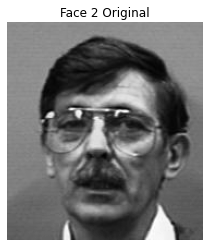

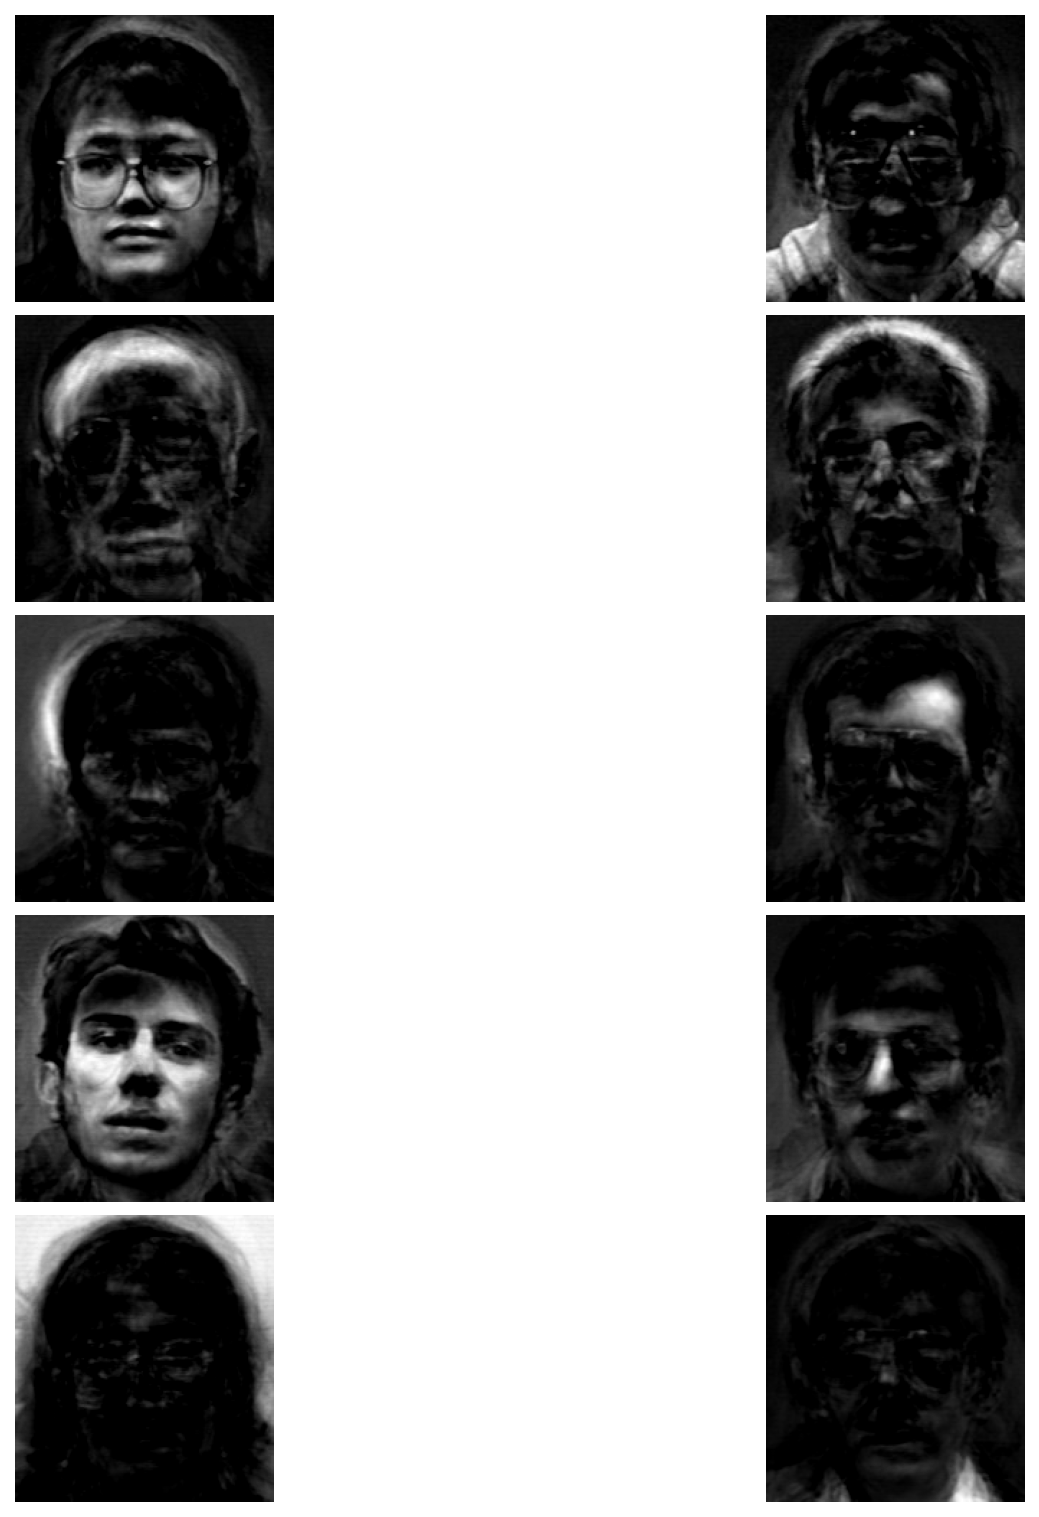

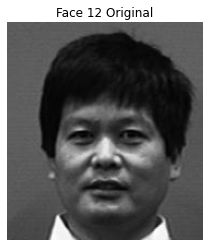

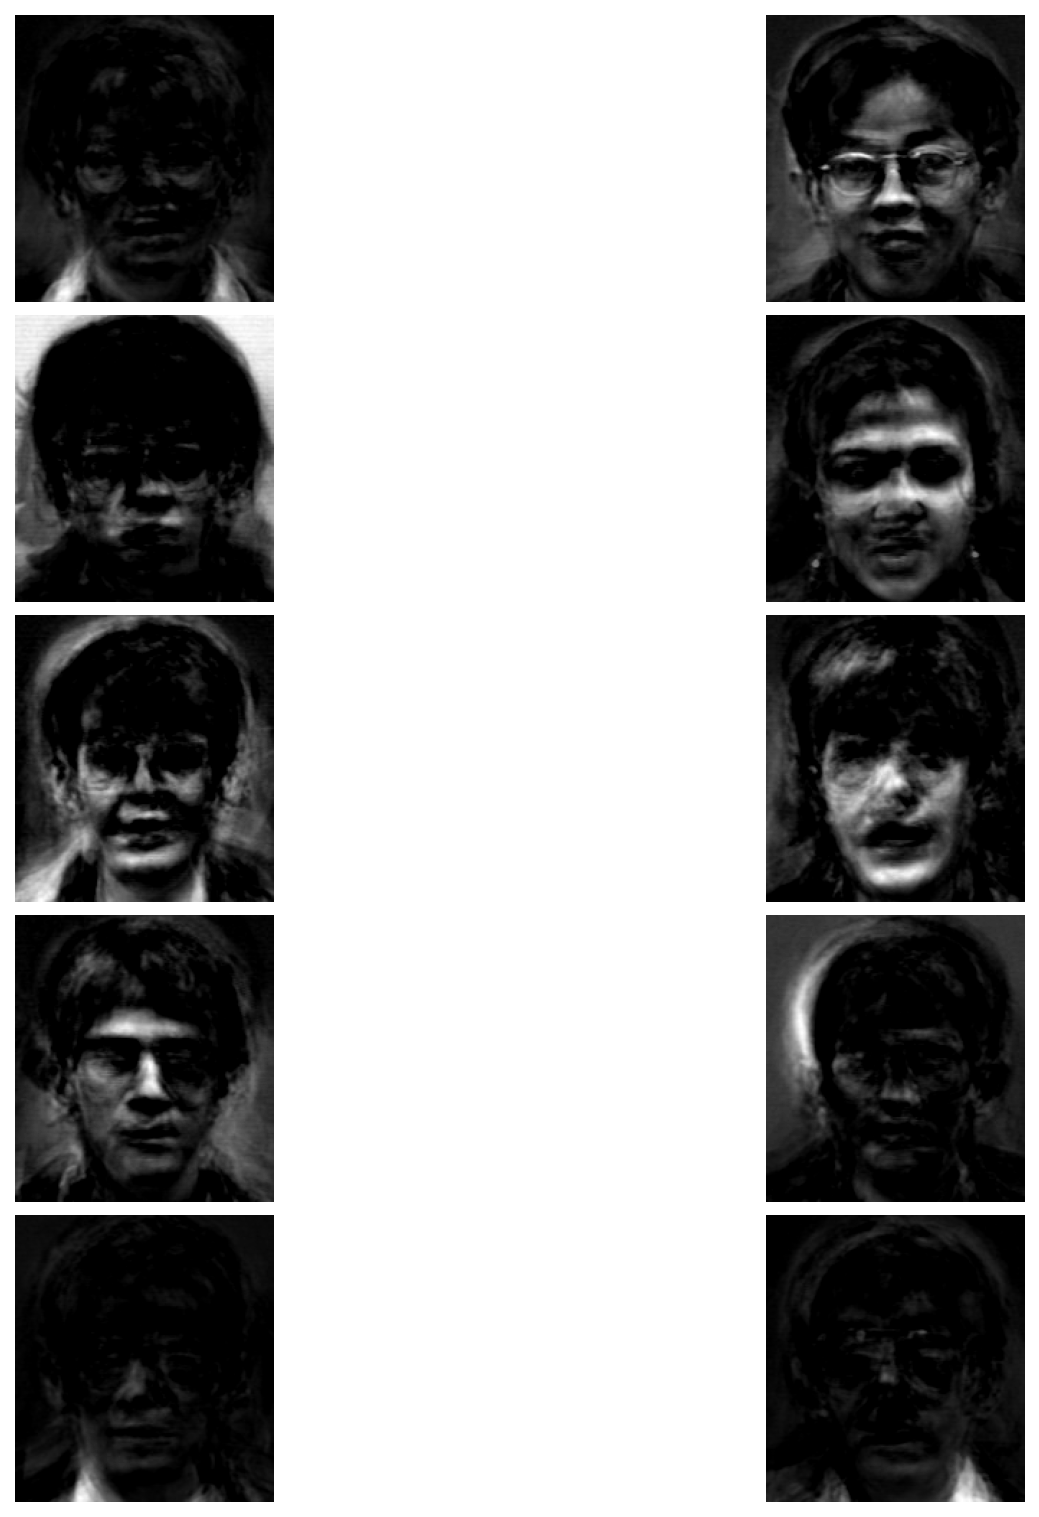

In [7]:
def prob5(n, alpha, l1):
    '''
        find the 10 basis faces with the largest coefficients 
        corresponding to the the second and twelfth face in the dataset. 
        Plot these basis faces along with the original image using 
        subplots
    '''
    # load faces dataset
    faces = get_faces()
    # get model
    model = NMF(n_components=n, alpha=alpha, l1_ratio=l1)
    W = model.fit_transform(faces)
    H = model.components_

    ######################
    # Second Face
    ######################
    show(faces[:, 1])
    plt.title('Face 2 Original')
    plt.axis('off')
    plt.show()

    # now we get the top basis faces for face 2
    fig, _ = plt.subplots(figsize=(10, 10), constrained_layout=True)
    fig.set_dpi(150)
    j = 1
    for i in np.argsort(H[:, 1])[-10:]:
        plt.subplot(5, 2, j)
        show(W[:, i]) 
        plt.axis('off')
        j += 1

    plt.show()

    ######################
    # Twelfth Face
    ######################
    show(faces[:, 11])
    plt.title('Face 12 Original')
    plt.axis('off')
    plt.show()

    # now we get the top basis faces for face 12
    fig, _ = plt.subplots(figsize=(10, 10), constrained_layout=True)
    fig.set_dpi(150)
    j = 1
    for i in np.argsort(H[:, 11])[-10:]:
        plt.subplot(5, 2, j)
        show(W[:, i]) 
        plt.axis('off')
        j += 1

    plt.show()

    return

prob5(75, 0.2, 10)